In [18]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


### Import Data & Packages

In [19]:
import pandas as pd
import numpy as np
import statistics
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [56]:
# unknown and 999 should be treated as missing values
df = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df = df.drop(columns = ['duration']) # drop future information

# deal with campaign
# remove future information
df['ncalls'] = df['campaign'] - 1
df = df.drop(columns = ['campaign'])

In [21]:
np.unique(df.pdays, return_counts = True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 25., 26., 27.,
        nan]),
 array([   15,    26,    61,   439,   118,    46,   412,    60,    18,
           64,    52,    28,    58,    36,    20,    24,    11,     8,
            7,     3,     1,     2,     3,     1,     1,     1, 39673]))

In [57]:
# deal with pdays
def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df['pdays'] = df['pdays'].apply(categorize_pdays)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ncalls
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,never contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,never contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,never contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,never contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,never contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [58]:
df = df.drop(columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

In [24]:
np.unique(df.pdays, return_counts = True)

(array(['contacted between 15 to 21 days',
        'contacted between 22 to 28 days',
        'contacted between 8 to 14 days', 'contacted immediately',
        'contacted within a week', 'never contacted'], dtype=object),
 array([   56,     6,   276,    15,  1162, 39673]))

In [25]:
np.unique(df['y'], return_counts = True)

(array(['no', 'yes'], dtype=object), array([36548,  4640]))

In [59]:
X = df.drop(columns = 'y')
y = df['y']
y = y.replace({'yes': 1, 'no': 0})
print(X.shape)
print(y.shape)

(41188, 14)
(41188,)


### Define Preprocessor

In [60]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
#ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
#                 'professional.course', 'university.degree'],
#                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
#                ['mon', 'tue', 'wed', 'thu', 'fri'], 
#                ['never contacted', 'contacted between 22 to 28 days', 'contacted between 15 to 21 days',
#                 'contacted between 8 to 14 days', 'contacted within a week', 'contacted immediately']]

num_ftrs = ['age', 'previous', 'ncalls']

In [61]:
# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

### ML Function: beta = 1

In [29]:
from sklearn.metrics import average_precision_score, accuracy_score, fbeta_score, precision_recall_curve, make_scorer

def MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 5):
    test_scores = []
    best_models = []
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    for i, random_state in enumerate(random_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, random_state = 42 * random_state, test_size = 0.2)
        # imbalanced data set
        kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42 * random_state)
        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state = 42 * random_state)
        else:
            ML_algo = ML_algo

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid,
                            scoring = fbeta_scorer, cv = kf,
                            return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        #print('Best model parameter(s):', grid.best_params_)
        #print('Validation score:', grid.best_score_)
        best_models.append(grid) # save the model
        #y_test_pred_prob = best_models[-1].predict_proba(X_test)[:, 1]
        y_test_pred = best_models[-1].predict(X_test)

        # confusion matrix
        #cm = confusion_matrix(y_test, y_test_pred)
        #disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
        #fig, ax = plt.subplots(figsize = (5, 3))
        #disp.plot(ax = ax)
        #plt.tight_layout()
        #plt.show()
        
        test_fbeta = fbeta_score(y_test, y_test_pred, beta = 1)
        test_scores.append(test_fbeta)
        #print('Test average precision:', test_scores[i])
    return test_scores, best_models

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

random_states = [42, 123, 456]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_rf, best_models_rf = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_rf))
print('Standard deviation:', np.std(test_scores_rf))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean: 0.4439666494914973
Standard deviation: 0.016202323421789306


In [31]:
best_models_rf[0]

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1764, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'previous',
                                                                          'ncalls']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder...
                                        RandomForestClassifier(random_state=19152))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': [None,
                                                                  'balanced',
                                                                  'balanced_subsample',
                                                                  {0: 1, 1: 5},
                                                                  {0: 1,
                                                                   1: 10}],
                         'randomforestclassifier__max_depth': [1, 3, 10, 30,
                                                               100],
                         'randomforestclassifier__max_features': [0.15, 0.5,
                                                                  0.75, 1]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=1),
             verbose=True)

### Logistic

In [32]:
from sklearn.linear_model import LogisticRegression

random_states = [42, 123, 456]
ML_algo = LogisticRegression(solver = 'saga', penalty = None, max_iter = 1000000)
param_grid = {
    'logisticregression__class_weight': [None, 'balanced', 
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_log, best_models_log = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_log))
print('Standard deviation:', np.std(test_scores_log))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mean: 0.3588044677285094
Standard deviation: 0.01019239714494548


### Ridge

In [33]:
random_states = [42, 123, 456]
ML_algo = LogisticRegression(solver = 'saga', penalty = 'l2', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__class_weight': [None, 'balanced', 
                                         {0: 1, 1: 5}, {0: 1, 1: 10}],
    
}

test_scores_l2, best_models_l2 = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)
print('Mean:', np.mean(test_scores_l2))
print('Standard deviation:', np.std(test_scores_l2))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mean: 0.35891420765619414
Standard deviation: 0.010273732030678977


### Elasticnet

In [34]:
random_states = [42, 123, 456]
ML_algo = LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__l1_ratio': [0.3, 0.5, 0.8],
    'logisticregression__class_weight': [None, 'balanced',
                                         {0: 1, 1: 5}, {0: 1, 1: 10}]
}

test_scores_en, best_models_en = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)
print('Mean:', np.mean(test_scores_en))
print('Standard deviation:', np.std(test_scores_en))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mean: 0.35734941305189366
Standard deviation: 0.009324034085261926


### Lasso

In [37]:
random_states = [42, 123, 456]
ML_algo = LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 1000000)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__class_weight': [None, 'balanced', 
                                         {0: 1, 1: 5}, {0: 1, 1: 10}],
    
}

test_scores_l1, best_models_l1 = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)
print('Mean:', np.mean(test_scores_l1))
print('Standard deviation:', np.std(test_scores_l1))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mean: 0.35923186454270706
Standard deviation: 0.010518533064621534


In [ ]:
ML_algo = XGBClassifier()
ML_algo.get_params().keys()

### XGBoost

In [208]:
df_missing = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df_missing = df_missing.drop(columns = ['duration']) # drop future information
df_missing['ncalls'] = df_missing['campaign'] - 1
df_missing = df_missing.drop(columns = ['campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,y,ncalls
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,NaN,0,nonexistent,no,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,NaN,0,nonexistent,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,NaN,0,nonexistent,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,NaN,0,nonexistent,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,NaN,0,nonexistent,no,0


In [209]:
X = df_missing.drop(columns = 'y')
y = df_missing['y']
y = y.replace({'yes': 1, 'no': 0})
print(X.shape)
print(y.shape)

(41188, 14)
(41188,)


In [210]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri']]

num_ftrs = ['age', 'previous', 'ncalls', 'pdays']

In [211]:
# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [221]:
import xgboost
from xgboost import XGBClassifier

def MLpipe_XGBoost(X, y, preprocessor, random_states):
    test_scores = []
    train_scores = []
    best_models = []
    test_sets = [] # save each random state's test set into a list
    #fbeta_scorer = make_scorer(fbeta_score, beta = 1.3)

    for random_state in random_states:
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size = 0.6,
                                                              random_state = 42 * random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size = 0.5,
                                                        random_state = 42 * random_state)
        # preprocessing
        df_train = pd.DataFrame(data = preprocessor.fit_transform(X_train), 
                                columns = preprocessor.get_feature_names_out())
        df_val = pd.DataFrame(data = preprocessor.transform(X_val), 
                              columns = preprocessor.get_feature_names_out())
        df_test = pd.DataFrame(data = preprocessor.transform(X_test), 
                               columns = preprocessor.get_feature_names_out())

        # save each random state's test set into a list
        # save both the feature matrix and the target series
        df_y = pd.DataFrame(data = y_test, columns = ['y']).reset_index(drop = True)
        df_test1 = df_test.reset_index(drop = True)
        df_combined = pd.concat([df_test1, df_y], axis = 1)
        test_sets.append(df_combined)
        
        param_grid = {
            'max_depth': [1, 3, 10, 30, 100],
            'learning_rate': [0.33],
            'n_estimators': [10000],
            'seed': [0],
            'reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            'subsample': [0.66],
            'colsample_bytree': [0.9],
            'scale_pos_weight': [1, 7.87]
        }
       
        best_fbeta_score = 0
        best_model = None
        best_params = None

        for params in ParameterGrid(param_grid):
            clf = XGBClassifier(random_state = 42 * random_state)
            clf.set_params(**params, early_stopping_rounds = 50)
            clf.fit(df_train, y_train, eval_set = [(df_val, y_val)], 
                    verbose = False)
            y_val_pred = clf.predict(df_val)
            fbeta_score_val = fbeta_score(y_val, y_val_pred, beta = 1)
            if fbeta_score_val > best_fbeta_score:
                best_fbeta_score = fbeta_score_val
                best_model = clf
                best_params = params
       
        best_models.append(best_model)
        train_score = fbeta_score(y_train, best_model.predict(df_train), beta = 1)
        test_score = fbeta_score(y_test, best_model.predict(df_test), beta = 1)
        test_scores.append(test_score)
        train_scores.append(train_score)
                            
    print(f'Mean: {np.mean(test_scores)}')
    print(f'Standard deviation: {np.std(test_scores)}')
    return best_models, test_scores, test_sets

In [222]:
# leave the pdays as missing
random_states = [42, 123, 456]
best_models_xgb_missing, test_scores_xgb_missing, test_sets_xgb_missing = MLpipe_XGBoost(X, y, preprocessor, random_states)

Mean: 0.41682024442936116
Standard deviation: 0.004406538874193739


In [226]:
df = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df = df.drop(columns = ['duration']) # drop future information
df['ncalls'] = df['campaign'] - 1
df = df.drop(columns = ['campaign'])

def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df['pdays'] = df['pdays'].apply(categorize_pdays)
df = df.drop(columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])
X = df.drop(columns = 'y')
y = df['y']
y = y.replace({'yes': 1, 'no': 0})
print(X.shape)
print(y.shape)

(41188, 14)
(41188,)


In [227]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
#ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
#                 'professional.course', 'university.degree'],
#                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
#                ['mon', 'tue', 'wed', 'thu', 'fri'], 
#                ['never contacted', 'contacted between 22 to 28 days', 'contacted between 15 to 21 days',
#                 'contacted between 8 to 14 days', 'contacted within a week', 'contacted immediately']]

num_ftrs = ['age', 'previous', 'ncalls']

# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [228]:
# make pdays into ordinal features
random_states = [42, 123, 456]
best_models_xgb_ord, test_scores_xgb_ord, test_sets_xgb_ord = MLpipe_XGBoost(X, y, preprocessor, random_states)

Mean: 0.4228373617963494
Standard deviation: 0.006367109270544509


### KNN

In [241]:
from sklearn.neighbors import KNeighborsClassifier

random_states = [42, 123, 456]
ML_algo = KNeighborsClassifier()
param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 3, 5, 10, 30, 100, 300],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

test_scores_knn, best_models_knn = MLpipe_KFold_fbeta(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

print('Mean:', np.mean(test_scores_knn))
print('Standard deviation:', np.std(test_scores_knn))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Mean: 0.286055107431805
Standard deviation: 0.004285523595325485


### Test Scores

In [67]:
# baseline
tp = 4640
fp = 36548
fn = 0
r = tp / (tp + fn)
p = tp / (tp + fp)
base = (2 * p * r) / (p + r); base

0.2024962904774374

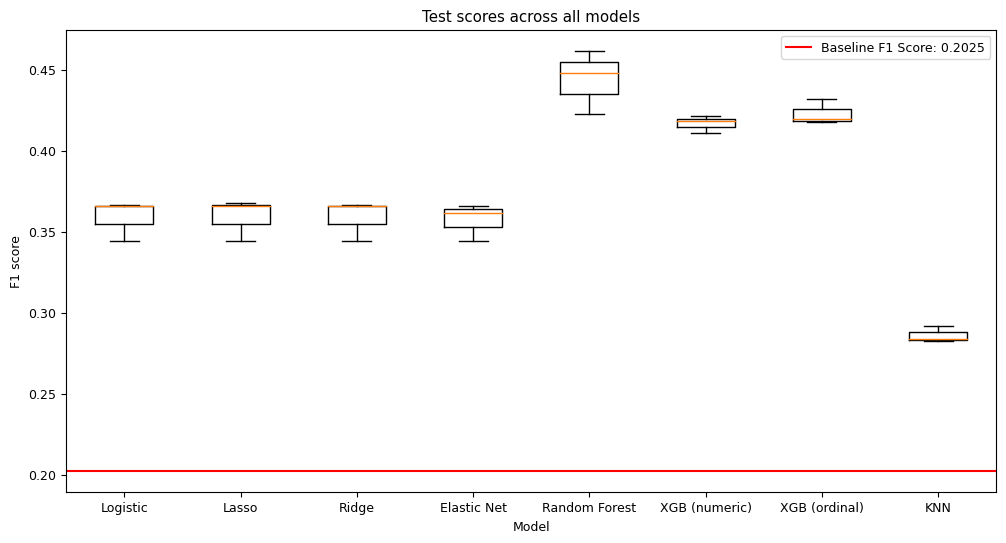

In [243]:
all_test_scores = [test_scores_log, test_scores_l1, test_scores_l2, test_scores_en, test_scores_rf, test_scores_xgb_missing, 
                   test_scores_xgb_ord, test_scores_knn]
plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 9})
plt.boxplot(all_test_scores)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['Logistic', 'Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 
                                   'XGB (numeric)', 'XGB (ordinal)', 'KNN'])
plt.title('Test scores across all models')
plt.ylabel('F1 score')
plt.xlabel('Model')
plt.axhline(y = base, color = 'r', linestyle = '-', label = f'Baseline F1 Score: {base:.4f}')
plt.legend()
plt.savefig('/Users/ihiro/Desktop/boxplot_scores.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Confusion matrix

In [206]:
def MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 5):
    test_scores = []
    best_models = []
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    for i, random_state in enumerate(random_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, random_state = 42 * random_state, test_size = 0.2)
        # imbalanced data set
        kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42 * random_state)
        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state = 42 * random_state)
        else:
            ML_algo = ML_algo

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid,
                            scoring = fbeta_scorer, cv = kf,
                            return_train_score = True, n_jobs = -1, verbose = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        #print('Best model parameter(s):', grid.best_params_)
        #print('Validation score:', grid.best_score_)
        best_models.append(grid) # save the model
        #y_test_pred_prob = best_models[-1].predict_proba(X_test)[:, 1]
        y_test_pred = best_models[-1].predict(X_test)

        # confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels = ['Class 0', 'Class 1'])
        fig, ax = plt.subplots(figsize = (5, 3))
        disp.plot(ax = ax)
        plt.tight_layout()
        plt.title('Confusion matrix in random forest')
        plt.savefig('/Users/ihiro/Desktop/confusion_matrix.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        test_fbeta = fbeta_score(y_test, y_test_pred, beta = 1)
        test_scores.append(test_fbeta)
        #print('Test average precision:', test_scores[i])
    return test_scores, best_models

Fitting 3 folds for each of 100 candidates, totalling 300 fits


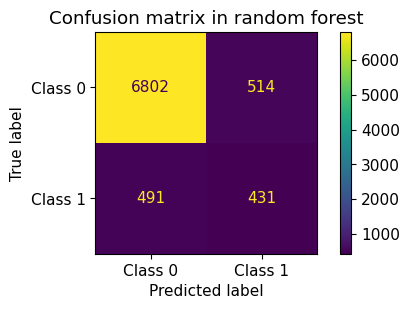

In [207]:
random_states = [42]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

a, b = MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

### Interpretability

In [ ]:
df1 = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown', 999])
df1 = df1.drop(columns = ['duration']) # drop future information
df1['ncalls'] = df1['campaign'] - 1
df1 = df1.drop(columns = ['campaign'])

In [ ]:
def categorize_pdays(days):
    if np.isnan(days):
        return 'never contacted'
    elif days == 0:
        return 'contacted immediately'
    elif days <= 7:
        return 'contacted within a week'
    elif days <= 14:
        return 'contacted between 8 to 14 days'
    elif days <= 21:
        return 'contacted between 15 to 21 days'
    elif days <= 28:
        return 'contacted between 22 to 28 days'
    else:
        return 'contacted after 28 days'

df1['pdays'] = df1['pdays'].apply(categorize_pdays)
print(df1.shape)

In [ ]:
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri'], 
                ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                 'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
num_ftrs = ['age', 'previous', 'ncalls', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
            'euribor3m', 'nr.employed']

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
    ('scaler', StandardScaler())])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
    ('scaler', StandardScaler())])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [ ]:
random_states = [42]
ML_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', 
                                             {0: 1, 1: 5}, {0: 1, 1: 10}]
}

c, d = MLpipe_KFold_cm(X, y, random_states, preprocessor, ML_algo, param_grid, n_splits = 3)

### Global

In [101]:
def MLpipe_global(X, y, random_state, n_folds):
    fbeta_scorer = make_scorer(fbeta_score, beta = 1)
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 * random_state)
    kf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42 * random_state)
    cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']
    num_ftrs = ['age', 'previous', 'ncalls'] # numeric
    ordinal_ftrs = ['education', 'month', 'day_of_week', 'pdays']
    ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                     'professional.course', 'university.degree'],
                    ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                    ['mon', 'tue', 'wed', 'thu', 'fri'], 
                    ['contacted immediately', 'contacted within a week', 'contacted between 8 to 14 days',
                     'contacted between 15 to 21 days', 'contacted between 22 to 28 days', 'never contacted']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
        ('scaler', StandardScaler())])
    # ordinal encoder
    ordinal_transformer = Pipeline(steps = [
        ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
        ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
        ('scaler', StandardScaler())])
    # standard scaler
    numeric_transformer = Pipeline(steps = [
        ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, num_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ord', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor, RandomForestClassifier())
    param_grid = {
        'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
        'randomforestclassifier__max_features': [0.15, 0.5, 0.75, 1.0],
        'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample', {0: 1, 1: 5}, {0: 1, 1: 10}]
    }

    # prepare Gridsearch
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = fbeta_scorer,
                        cv = kf, return_train_score = True, n_jobs = -1,
                        verbose = True)
    grid.fit(X_other, y_other)
    y_test_pred = grid.predict(X_test)
    base_f1 = fbeta_score(y_test, y_test_pred, beta = 1)
    return grid, X_test, y_test, base_f1

In [102]:
model_42, X_test_42, y_test_42, base_42 = MLpipe_global(X, y, 42, 3)
model_123, X_test_123, y_test_123, base_123 = MLpipe_global(X, y, 123, 3)
model_456, X_test_456, y_test_456, base_456 = MLpipe_global(X, y, 456, 3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [126]:
best_pipe_42 = model_42.best_estimator_
best_model_42 = best_pipe_42.named_steps['randomforestclassifier']
importance_value_42 = best_model_42.feature_importances_ # 37 different values
ftr_names = best_pipe_42.named_steps['columntransformer'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': ftr_names, 'Importance': importance_value_42}).sort_values(by = 'Importance', 
                                                                                                    ascending = False).head(10)
importance_df

,Feature,Importance
36,ord__pdays,0.275334
34,ord__month,0.192498
0,num__age,0.115025
32,cat__poutcome_success,0.063490
28,cat__contact_cellular,0.058722
29,cat__contact_telephone,0.045817
2,num__ncalls,0.039112
20,cat__default_no,0.028243
35,ord__day_of_week,0.027446
33,ord__education,0.027341


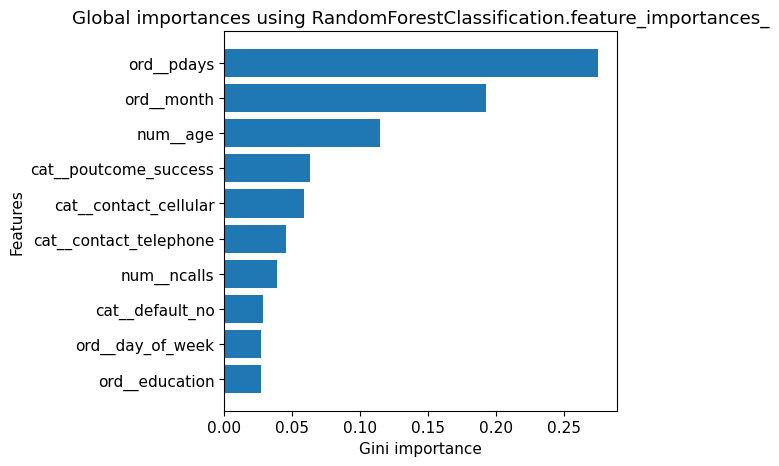

In [203]:
importance_df.sort_values(by = 'Importance', ascending = True, inplace = True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Gini importance')
plt.ylabel('Features')
plt.title('Global importances using RandomForestClassification.feature_importances_')
plt.tight_layout()
plt.savefig('/Users/ihiro/Desktop/global.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Local

In [134]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_42.best_estimator_[1])
X_test_transformed = model_42.best_estimator_[0].transform(X_test_42)
print(np.shape(X_test_transformed))

shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(8238, 37)
(2, 1000, 37)


In [176]:
index = 150
print(explainer.expected_value[1]) # class 1 pred proba
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][index,:], features = ftr_importances, 
                feature_names = ftr_names)

0.38797250204618805


In [174]:
ftr_importances = np.round(X_test_transformed[index,:], 3)
ftr_importances

array([-0.768, -0.351, -0.567, -0.582, -0.537, -0.192, -0.163, -0.277,
       -0.089, -0.21 , -0.187, -0.327, -0.146,  2.254, -0.159, -0.357,
       -1.236, -0.044,  1.602, -0.513,  0.513, -0.01 , -0.156, -0.906,
        0.95 , -0.156,  0.463, -0.425,  0.759, -0.759, -0.34 ,  0.399,
       -0.187,  0.553, -0.79 ,  1.434,  0.195])

In [182]:
index = 150
print(explainer.expected_value[1]) # class 1 pred proba
plt.figure(figsize = (20, 10))
plt.rcParams.update({'font.size': 11})
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][index,:], features = ftr_importances, 
                feature_names = ftr_names, show = False, matplotlib = True)
plt.savefig('/Users/ihiro/Desktop/force_plot.png', dpi = 300, bbox_inches = 'tight')

0.38797250204618805


### Global: SHAP

#### Try `summary_plot`

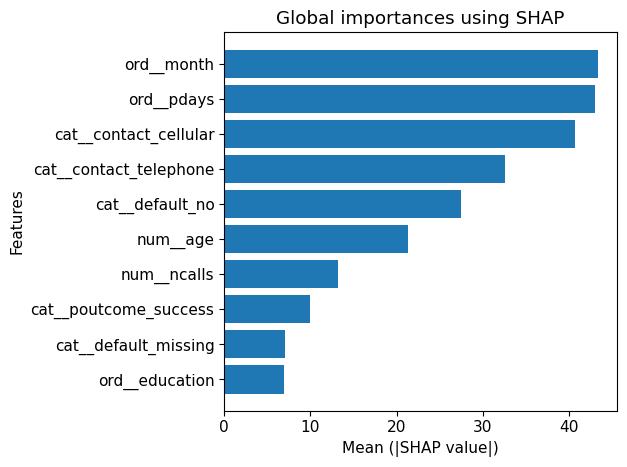

In [197]:
shap_summary = np.mean(np.abs(shap_values[1]), axis = 0) + np.sum(np.abs(shap_values[0]), axis = 0)
indcs = np.argsort(shap_summary)
shap_summary[indcs]
plt.barh(ftr_names[indcs[-10:]], shap_summary[indcs[-10:]])
plt.xlabel('Mean (|SHAP value|)')
plt.ylabel('Features')
plt.title('Global importances using SHAP')
plt.tight_layout()
plt.savefig('/Users/ihiro/Desktop/global_SHAP.png', dpi = 300, bbox_inches = 'tight')
plt.show()